In [1]:
%set_env SPARK_HOME=/opt/spark
import os
import findspark
import pandas as pd
os.environ['PYSPARK_SUBMIT_ARGS'] = """\
--master spark://10.62.42.237:7077 
--packages datastax:spark-cassandra-connector:2.3.1-s_2.11,anguenot:pyspark-cassandra:0.9.0
--driver-memory 8g
--executor-memory 3g
--conf spark.local.dir=/var/spark
--conf spark.network.timeout=100000s
--conf spark.executor.heartbeatInterval=10000s
--conf spark.shuffle.registration.timeout=10000s
pyspark-shell
"""


import pyspark
from pyspark import SparkContext, SparkConf
findspark.init()
sc = pyspark.SparkContext(appName="TimeOfDay")

sc._conf.set("spark.sql.execution.arrow.enabled", "true")
sc._conf.set('spark.driver.maxResultSize', '6g')
# sc._conf.set('spark.driver.cores', '4')
# sc._conf.set('spark.executor.cores', '4')
# sc._conf.set('spark.driver.memory', '24g')
# sc._conf.set('spark.executor.memory', '24g')
# sc._conf.set("spark.cores.max", 8)
sc._conf.set("spark.local.dir", "/var/spark")

# sc._conf.set("spark.network.timeout", "1000000s")
# sc._conf.set("spark.executor.heartbeatInterval", "1000000s")
#'10.224.12.32'

sc._conf.set("spark.cassandra.connection.host", "10.62.1.118")
sc._conf.set("spark.cassandra.auth.username", "mlprw")
sc._conf.set("spark.cassandra.auth.password", "q4RgwD$wK7*z")

sc._conf.getAll()

env: SPARK_HOME=/opt/spark


[('spark.master', 'spark://10.62.42.237:7077'),
 ('spark.driver.port', '22161'),
 ('spark.deploy.spreadOut', 'true'),
 ('spark.sql.execution.arrow.enabled', 'true'),
 ('spark.local.dir', '/var/spark'),
 ('spark.files',
  'file:///root/.ivy2/jars/datastax_spark-cassandra-connector-2.3.1-s_2.11.jar,file:///root/.ivy2/jars/anguenot_pyspark-cassandra-0.9.0.jar,file:///root/.ivy2/jars/com.twitter_jsr166e-1.1.0.jar,file:///root/.ivy2/jars/org.joda_joda-convert-1.2.jar,file:///root/.ivy2/jars/io.netty_netty-all-4.0.33.Final.jar,file:///root/.ivy2/jars/commons-beanutils_commons-beanutils-1.9.3.jar,file:///root/.ivy2/jars/joda-time_joda-time-2.3.jar,file:///root/.ivy2/jars/org.scala-lang_scala-reflect-2.11.8.jar,file:///root/.ivy2/jars/commons-collections_commons-collections-3.2.2.jar,file:///root/.ivy2/jars/com.datastax.spark_spark-cassandra-connector_2.11-2.3.0.jar,file:///root/.ivy2/jars/net.razorvine_pyrolite-4.10.jar,file:///root/.ivy2/jars/net.razorvine_serpent-1.12.jar'),
 ('spark.cassan

In [4]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
WORK_DIR = '/var/spark/ml_files/'
spark = SparkSession.builder.\
    master("spark://10.62.42.237:7077").\
    appName("TimeOfDay").\
    config(conf=sc._conf).\
    getOrCreate()
spark

sqlContext = SQLContext(sc)
sqlContext

In [35]:
import time

import pandas as pd


from pyspark.sql.types import *
from pyspark.sql.functions import col, count, rand, collect_list, explode, struct, count, lit, lower
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import pyspark_cassandra
        
import calendar, datetime
from datetime import timedelta


def convert_status(value):
    if value == 'Completed' or value == 'Reversed':
        return 1
    else:
        return 0

def _map_to_pandas(rdds):
    """ Needs to be here due to pickling issues """
    return [pd.DataFrame(list(rdds))]

def toPandas(df, n_partitions=None):
    """
    Returns the contents of `df` as a local `pandas.DataFrame` in a speedy fashion. The DataFrame is
    repartitioned if `n_partitions` is passed.
    :param df:              pyspark.sql.DataFrame
    :param n_partitions:    int or None
    :return:                pandas.DataFrame
    """
    if n_partitions is not None: df = df.repartition(n_partitions)
    df_pand = df.rdd.mapPartitions(_map_to_pandas).collect()
    df_pand = pd.concat(df_pand)
    df_pand.columns = df.columns
    return df_pand
    
udfValueToStatus = udf(convert_status, IntegerType())  
createDDL = """CREATE OR REPLACE TEMPORARY VIEW cpg_transaction_history
     USING org.apache.spark.sql.cassandra
     OPTIONS (
     table "cpg_transaction_history",
     keyspace "dev_sarsks",
     cluster "MLP Cluster",
     pushdown "true")"""
spark.sql(createDDL)

# df = spark.sql("SELECT * FROM cpg_transaction_history WHERE received_date > '2018-08-12' ")
df = spark.sql("SELECT * FROM cpg_transaction_history WHERE received_date > '2018-08-11' and  received_date < '2018-10-01' ")
# df = spark.sql("SELECT * FROM cpg_transaction_history")

sdf =  df\
    .withColumn("success", udfValueToStatus("new_status"))\
    .withColumn("day_of_month", df["day_of_month"].cast(IntegerType()))\
    .withColumn("transaction_hour", df["transaction_hour"].cast(IntegerType()))\
    .withColumn("day_of_week", lower(col("day_of_week")))\
    .withColumn("payment_amount_usd", df["payment_amount_usd"].cast(FloatType()))\
    .cache()

print(sdf.schema)

pdf_all =sdf.toPandas() 
# pdf_all = toPandas(sdf, 4)  
pdf_all.shape

StructType(List(StructField(received_date,DateType,true),StructField(site_id,StringType,true),StructField(subscription_id,StringType,true),StructField(transaction_id,StringType,true),StructField(transaction_date,TimestampType,true),StructField(added_expiry_years,StringType,true),StructField(bank_code,StringType,true),StructField(bank_name,StringType,true),StructField(billing_country,StringType,true),StructField(bin,StringType,true),StructField(card_brand,StringType,true),StructField(card_category,StringType,true),StructField(card_class,StringType,true),StructField(card_usage,StringType,true),StructField(cc_expiration_date,StringType,true),StructField(cid,StringType,true),StructField(date_increment,StringType,true),StructField(day_of_month,IntegerType,true),StructField(day_of_week,StringType,true),StructField(event_uuid,StringType,true),StructField(exp_setting_id,StringType,true),StructField(funding_source,StringType,true),StructField(issuer_country,StringType,true),StructField(merchant

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 11540)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/opt/anaconda3/lib/python3.6/site-packages/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/socketserver.py", line 317, in _handle_reques

(1842022, 46)

In [4]:
sc.stop()

In [36]:
pdf_all[pdf_all['bin'] == ''].head(20)

,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success
25765,2018-08-23,adbehme,11985934101,7254144073,2018-08-23 02:06:09,,NON3DS,"CITIBANK, N.A.",AE,,MasterCard,World Elite MasterCard Card,Consumer,True credit (No PIN/Signature capability),0422,,,23,thursday,1d16f609-b5fe-48cb-918a-388ffd9faef4,,Credit,AE,DRI*Adobe Systems,1156962062-AED-pacific,DR_IRELAND-ENTITY,Reversed,DR_IRELAND-ENTITY,57.75,15.724985,AED,MasterCard,netgiro-seb,2,57.75,15.724985,AED,51246620600,100,reversal SUCCESS,Completed,16773628200,2018-08-23 02:06:09,2,Authorize,1
45411,2018-08-23,avast,3847001001,7255474353,2018-08-23 08:45:56,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,8e3150f5-febb-4c50-ae02-6bb15920fc16,,,,DRI*AVAST Software,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,7.99,9.281184,EUR,SDD,slimpay,1,7.99,9.281184,EUR,51269740900,active,,New,16829715400,2018-08-23 08:45:56,8,Authorize,1
45490,2018-08-23,avast,5883712801,7254787823,2018-08-23 07:16:34,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,3bfd1d08-e9a9-41d3-a15e-ce4c956baaa4,,,,DRI*AVAST Software,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,7.99,9.281184,EUR,SDD,slimpay,1,7.99,9.281184,EUR,51268796400,active,,New,16834336000,2018-08-23 07:16:34,7,Authorize,1
45644,2018-08-23,avast,9154506701,7254481703,2018-08-23 04:45:26,,EXPORT_MANDATE,,AT,,,,,,,,,23,thursday,6602e95a-485d-4244-8d60-672a29d4f8eb,,,,DRI*AVAST Software,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,7.99,9.281184,EUR,SDD,slimpay,1,7.99,9.281184,EUR,51262810300,active,,New,16833745100,2018-08-23 04:45:26,4,Authorize,1
75927,2018-08-23,kasper,11125771801,7253903403,2018-08-23 01:34:24,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,ee8ee00b-c3f2-4227-9c02-a5aedb24eca3,,,,DRI*Kaspersky Lab,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,3.99,4.634784,EUR,SDD,slimpay,1,3.99,4.634784,EUR,51243609400,active,,New,16830628200,2018-08-23 01:34:24,1,Authorize,1
75928,2018-08-23,kasper,11125866401,7253903753,2018-08-23 01:34:25,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,6cf72a80-c6c8-47be-9635-ef6ab9816b29,,,,DRI*Kaspersky Lab,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,3.99,4.634784,EUR,SDD,slimpay,1,3.99,4.634784,EUR,51243611700,active,,New,16830722500,2018-08-23 01:34:25,1,Authorize,1
76140,2018-08-23,kasperde,10012023001,7254319633,2018-08-23 02:46:27,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,30c69749-5c09-41db-8959-07777b13f62a,,,,DRI*Kaspersky Lab,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,3.99,4.634784,EUR,SDD,slimpay,1,3.99,4.634784,EUR,51248041100,active,,New,16833420700,2018-08-23 02:46:27,2,Authorize,1
76141,2018-08-23,kasperde,10124107501,7257131913,2018-08-23 10:46:12,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,e38c8be9-72ff-4b61-b3b3-c10a2482575a,,,,DRI*Kaspersky Lab,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,3.99,4.634784,EUR,SDD,slimpay,1,3.99,4.634784,EUR,51270691500,active,,New,16834059000,2018-08-23 10:46:12,10,Authorize,1
76393,2018-08-23,kasperde,2020941109,7256304713,2018-08-23 09:15:36,,EXPORT_MANDATE,,DE,,,,,,,,,23,thursday,f10ffd09-6f0a-41ba-864c-a027bcd482f9,,,,DRI*Kaspersky Lab,digitalriver01,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,3.99,4.634784,EUR,SDD,slimpay,1,3.99,4.634784,EUR,51269920000,active,,New,16833130700,2018-08-23 09:15:36,9,Authorize,1
76784,2018-08-23,kasperde,3534456901,7257132063,2018-08-23 10:46:12,,

In [11]:
# bin_profile.to_csv(WORK_DIR + 'bin_profile_time_of_day.csv')

In [28]:
pdf_all['site_id'].value_counts()  # ['avgstore', 'avast', 'kasperus', 'avastbr', 'tmamer', 'kasper', 'kasperde', 'tmapac', 'kasperuk', 'kaspersk', 'kasperla', 'tmecon', 'avgbr', 'tmemea']

avgstore    940583
avast       878513
adbehap     566007
adbehkr     263947
kasperus    227303
cppro       218324
adbehbr     182803
avastbr     123537
adbehme     120651
adbehru     109310
adbeheu      97773
tmamer       95203
kasper       78678
adbehil      59322
kasperde     49400
adbehtw      46599
tmapac       27821
kasperuk     25856
kasperla     17528
ciscoctg     15416
kaspersk     13178
logib2c      10153
tmecon        8854
avgbr         8845
adsk          8050
kasperbr      7837
kaspernl      7716
tmemea        7614
defendde      6972
nuanceus      6730
             ...  
kasucpuk       350
tmoemem        331
gdatasw        292
cybscrub       238
kasucpbr       213
nuancesm       202
defenduk       174
defendwo       161
omron          142
tmoemap        104
adskcct         87
ca              84
tmpseu          68
techsmit        59
kasucpkr        55
tmpsus          51
cajapan         51
kasperoe        48
caconsum        46
sapsubs         32
kasucpla        32
netapp      

In [51]:
"""Generates bin_profile based on payment_amount_usd"""
grouped = pdf_all['payment_amount_usd'].groupby(pdf_all['bin']).agg([('Mean','mean'),('Min','min'),('Max','max'),('StdDev','std'),'count']).reset_index()
bin_profile = grouped[grouped['count'] >= 20]
bin_profile = bin_profile[bin_profile['bin'] != '']
bin_profile

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,bin,Mean,Min,Max,StdDev,count
44,354035,171.332825,18.275478,1695.485107,366.251129,22
67,354102,336.178802,39.132500,1762.466553,472.294128,28
68,354103,186.487152,2.690000,849.919373,220.998566,41
99,357300,74.148285,8.070000,282.365570,86.108360,22
112,358277,128.297073,17.968691,567.421265,188.504211,28
117,358403,99.556259,7.960079,2628.920654,257.693237,122
121,358419,158.281662,18.364580,568.102966,176.780090,28
126,358622,58.165367,18.382374,397.269623,70.677002,26
139,358761,135.421799,18.364580,568.102966,201.559708,25
141,358787,140.534119,2.690000,564.731140,192.293930,25


In [38]:
bin_profile = pd.read_csv(WORK_DIR + 'bin_profile_time_of_day.csv')

In [39]:
txn_count_all = pdf_all.groupby('transaction_hour')[('site_id')].count().reset_index().rename(columns={'site_id':'total_count'})
txn_count_processor = pdf_all.groupby(['transaction_hour', 'payment_service_id'])[('site_id')].count().reset_index().rename(columns={'site_id':'processor_count'})
txn_count_all = pd.merge(txn_count_processor, txn_count_all, left_on='transaction_hour', right_on='transaction_hour', how='left')
txn_count_all

,transaction_hour,payment_service_id,processor_count,total_count
0,0,adyen,7425,286964
1,0,drwp-discover,11,286964
2,0,drwp-dlocal,2902,286964
3,0,drwp-dlocal-auto,902,286964
4,0,drwp-fd,4782,286964
5,0,firstdata,13606,286964
6,0,litle,8591,286964
7,0,mes,10980,286964
8,0,nab,6907,286964
9,0,netgiro-amex,3341,286964


In [41]:
# site_ids = ['avgstore', 'avast', 'kasperus', 'avastbr', 'tmamer', 'kasper', 'kasperde', 'tmapac', 'kasperuk', 'kaspersk', 'kasperla', 'tmecon', 'avgbr', 'tmemea']
site_ids = ['avgstore', 'avast', 'kasperus', 'avastbr', 'tmamer', 'kasper', 'kasperde', 'tmapac', 'kasperuk', 'kaspersk', 'kasperla', 'tmecon', 'avgbr', 'tmemea']

pdf_f = pdf_all[pdf_all['site_id'].isin(site_ids)]

In [52]:
"""Merges the bin profile with the original data"""
pdf_all_bin_profile = pd.merge(pdf_f, bin_profile[['bin','Mean','Min','Max','StdDev']], left_on='bin', right_on='bin', how='left')
pdf_all_bin_profile.shape

(1069014, 50)

In [54]:
pdf_all_bin_profile_with_count = pd.merge(pdf_all_bin_profile, txn_count_all[['transaction_hour', 'payment_service_id','processor_count','total_count']], left_on=['transaction_hour', 'payment_service_id'], right_on=['transaction_hour', 'payment_service_id'], how='left')
# pdf_all_bin_profile_with_count = pdf_all_bin_profile_with_count.drop(['Unnamed: 0'], axis=1)
pdf_all_bin_profile_with_count.shape  #(2452800, 46), (876794, 49)

(1069014, 52)

In [55]:
pdf_all_bin_profile_with_count.head()

,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,Mean,Min,Max,StdDev,processor_count,total_count
0,2018-08-23,avast,10010341101,7253629653,2018-08-23 00:59:05,,NON3DS,ASB Bank,NZ,454860,Visa,Visa Classic,Consumer,True credit (No PIN/Signature capability),0721,,,23,thursday,8667914f-33dc-49dd-a147-8f1bed0d4af1,,Credit,NZ,DRI*AVAST Software,1411163460-NZD-pacific,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,120.74,80.981339,NZD,Visa,netgiro-bms,1,120.74,80.981341,NZD,51240340500,0,SUCCESS[00] [085435] [111800] [111800],New,14128632900,2018-08-23 00:59:05,0,Authorize,1,58.889027,2.242418,263.080139,28.488817,78782,286964
1,2018-08-23,avast,10017086901,7253627313,2018-08-23 00:58:51,4,7AC38540376F98E6,COMMONWEALTH BANK OF AUSTRALIA,AU,535316,MasterCard,(Unembossed) Standard MasterCard Card,Consumer,True credit (No PIN/Signature capability),11/21,,4,23,thursday,745d8732-b0ad-4c7c-a670-49f259470b62,3837631,Credit,AU,DRI*AVAST Software,I7A0010,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,89.99,66.222603,AUD,MasterCard,nab,3,89.99,66.222606,AUD,51240301600,201,14: Invalid card number,New,14027823500,2018-08-23 00:58:51,0,Authorize,0,72.325050,2.150167,1676.120483,78.193619,6907,286964
2,2018-08-23,avast,10021676301,7258325943,2018-08-23 16:15:39,,847B99784061F302,"Bank of America, National Association",US,481583,Visa,Visa Classic,Consumer,Debit Hybrid (PIN and Signature),0719,,,23,thursday,203cb185-c4e1-48e4-bcd4-9a5bdb8b8def,,Debit,US,DRI*AVAST Software,311009012882,DR_INC-ENTITY,Completed,DR_INC-ENTITY,49.99,49.990002,USD,Visa,firstdata,1,49.99,49.99,USD,51272738900,100,00: Approved,New,13299211100,2018-08-23 16:15:39,16,Authorize,1,59.275539,2.490000,295.000000,34.913464,19888,48311
3,2018-08-23,avast,10022230801,7253625563,2018-08-23 00:58:40,,NON3DS,Firstrand Bank Limited,ZA,422824,Visa,Visa Business,Business,True credit (No PIN/Signature capability),0319,,,23,thursday,60687471-9170-4e3f-9f62-5ead60002ed6,,Credit,ZA,DRI*AVAST Software,1156962062,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,499,34.959465,ZAR,Visa,netgiro-seb,3,499,34.959464,ZAR,51240294900,27001,Transaction refused[05] [000000] [] [],New,13302716400,2018-08-23 00:58:40,0,Authorize,0,62.072979,14.940000,149.949997,53.851498,122681,286964
4,2018-08-23,avast,10022230801,7253625783,2018-08-23 00:58:41,,NON3DS,Firstrand Bank Limited,ZA,422824,Visa,Visa Business,Business,True credit (No PIN/Signature capability),0319,RETRY_DECLINED.2,,23,thursday,2e6e8cbc-cd6f-433c-b622-5da03937b520,,Credit,ZA,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,499,34.959465,ZAR,Visa,netgiro-bms,3,499,34.959464,ZAR,51240294900,27001,Transaction refused[05] [] [111800] [111800],New,13302716400,2018-08-23 00:58:41,0,Authorize,0,62.072979,14.940000,149.949997,53.851498,78782,286964


In [33]:
"""Show all columns"""
import pandas as pd
from IPython.display import display

pd.options.display.max_columns = None
display(pdf_all_bin_profile)

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,Mean,Min,Max,StdDev
0,0,2018-08-21,acd,10418939801,7242559663,2018-08-21 02:01:37,NaN,99E4C41E4E4B59BE,"FIDELITY INFORMATION SERVICES,",US,546249.0,MasterCard,Standard Debit MasterCard,Consumer,Debit Hybrid (PIN and Signature),1020,NaN,NaN,21,tuesday,a597e6d6-42e9-4e39-9235-611ca4e65242,NaN,Debit,US,DRI*ACD Systems,7236084,DR_INC-ENTITY,Declined,DR_INC-ENTITY,18.39,18.390000,USD,MasterCard,litle,3.0,18.39,18.390000,USD,51169974900,201,301: Invalid Account Number,New,13959688600,2018-08-21 02:01:37,2,Authorize,0,69.300690,5.400000,171.590000,26.950033
1,1,2018-08-21,acd,10465808701,7242603393,2018-08-21 02:18:30,NaN,5793D55C64FB212A,COMMONWEALTH BANK OF AUSTRALIA,AU,521729.0,MasterCard,Standard Debit MasterCard,Consumer,NON USA Consumer Debit - Pin Capable,04/20,NaN,NaN,21,tuesday,c4dcd6d0-a4a8-4432-bd8d-0ee06b9c91a7,NaN,Debit,AU,DRI*ACD Systems,I7A0010,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,25.30,18.484165,AUD,MasterCard,nab,2.0,25.30,18.484166,AUD,51170426700,502,41: Lost card. Pick Up,New,14050444900,2018-08-21 02:18:30,2,Authorize,0,57.038130,2.177171,2108.688500,60.976078
2,2,2018-08-21,acd,10467977001,7242614223,2018-08-21 02:22:24,NaN,NON3DS,Ulster Bank Ireland Designated Activity Company,IE,431932.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1220,NaN,NaN,21,tuesday,5c281916-acbf-4a6e-a4bd-117f4deb7083,NaN,Debit,IE,DRI*ACD Systems,1411163460,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,27.06,30.902520,EUR,Visa,netgiro-bms,1.0,27.06,30.902520,EUR,51170531200,0,SUCCESS[00] [291830] [111800] [111800],New,14055928900,2018-08-21 02:22:24,2,Authorize,1,59.094670,3.060000,184.440000,24.925095
3,3,2018-08-21,acd,2852088109,7242339943,2018-08-21 00:23:04,0.0,B126DD5EE1A9F604,NaN,IT,375250.0,American Express,NaN,NaN,True credit (No PIN/Signature capability),0517,NaN,0.0,21,tuesday,99ca804b-c612-42b5-9430-0949c8ccbaf1,3892191.0,NaN,NaN,DRI*ACD Systems,941000108071_00000001,DR_INC-ENTITY,Declined,DR_IRELAND-ENTITY,20.00,20.000000,USD,AmericanExpress,mes,2.0,20.00,20.000000,USD,51167458200,530,005: Do not honor,New,14038591000,2018-08-21 00:23:04,0,Authorize,0,56.998210,9.990000,552.689300,100.698630
4,4,2018-08-21,acd,2852088109,7242340063,2018-08-21 00:23:05,0.0,B126DD5EE1A9F604,NaN,IT,375250.0,American Express,NaN,NaN,True credit (No PIN/Signature capability),0517,RETRY_DECLINED.2,0.0,21,tuesday,cea1d8ef-b599-430f-86fd-d8f355a1ff27,3892191.0,NaN,NaN,DRI*ACD Systems,311009012882,DR_INC-ENTITY,Declined,DR_IRELAND-ENTITY,20.00,20.000000,USD,AmericanExpress,firstdata,2.0,20.00,20.000000,USD,51167458200,530,51: DECLINED,New,14038591000,2018-08-21 00:23:05,0,Authorize,0,56.998210,9.990000,552.689300,100.698630
5,5,2018-08-21,acd,2852088209,7242338563,2018-08-21 00:22:25,0.0,B126DD5EE1A9F604,NaN,IT,375250.0,American Express,NaN,NaN,True credit (No PIN/Signature capability),0517,NaN,0.0,21,tuesday,5dbce3cc-66e8-4bd5-8967-f949f682bfa8,3892191.0,NaN,NaN,DRI*ACD Systems,941000108071_00000001,DR_INC-ENTITY,Declined,DR_IRELAND-ENTITY,16.99,16.990000,USD,AmericanExpress,mes,2.0,16.99,16.990000,USD,51167433300,530,005: Do not honor,New,14038581300,2018-08-21 00:22:25,0,Authorize,0,56.998210,9.990000,552.689300,100.698630
6,6,2018-08-21,acd,2852088209,7242338603,2018-08-21 00:22:26,0.0,B126DD5EE1A9F604,NaN,IT,375250.0,American Express,NaN,NaN,True credi

In [72]:
# pdf_debit = pdf_f[pdf_f['funding_source'] == 'Debit']
# pdf_debit.to_csv(WORK_DIR + 'TOD_Debit_Avast_TM_Kasper.csv')
# pdf_debit.shape   

pdf_debit = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['funding_source'] == 'Debit']
pdf_debit.to_csv(WORK_DIR + 'TOD_Debit_Avast_TM_Kasper.csv')
pdf_debit.shape   



(383066, 52)

In [71]:
pdf_debit.head()

,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,Mean,Min,Max,StdDev,processor_count,total_count
2,2018-08-23,avast,10021676301,7258325943,2018-08-23 16:15:39,,847B99784061F302,"Bank of America, National Association",US,481583,Visa,Visa Classic,Consumer,Debit Hybrid (PIN and Signature),0719,,,23,thursday,203cb185-c4e1-48e4-bcd4-9a5bdb8b8def,,Debit,US,DRI*AVAST Software,311009012882,DR_INC-ENTITY,Completed,DR_INC-ENTITY,49.99,49.990002,USD,Visa,firstdata,1,49.99,49.99,USD,51272738900,100,00: Approved,New,13299211100,2018-08-23 16:15:39,16,Authorize,1,59.275539,2.490000,295.000000,34.913464,19888,48311
9,2018-08-23,avast,10031628001,7254482713,2018-08-23 04:45:33,,RB,CREDIT AGRICOLE S.A.,FR,513106,MasterCard,Gold MasterCard Card Immediate Debit,Consumer,NON USA Consumer Debit - No Pin Access,0119,,,23,thursday,6f5025f0-52fd-4451-8b9f-65f8ab8ee405,,Debit,FR,DRI*AVAST Software,1785390597,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,7.99,9.281184,EUR,MasterCard,netgiro-bnp,1,7.99,9.281184,EUR,51262881100,0,SUCCESS[00] [592475] [] [],New,16833482500,2018-08-23 04:45:33,4,Authorize,1,61.118084,9.281184,115.698425,26.015802,5346,56364
10,2018-08-23,avast,10036725801,7254313803,2018-08-23 02:45:55,,16B2EEC78A2D3D8C,"Wells Fargo Bank, National Association",US,434258,Visa,Visa Classic,Consumer,Debit Hybrid (PIN and Signature),0619,,,23,thursday,13010b22-ef46-4e58-8900-c8c2b8e444d8,,Debit,US,DRI*AVAST Software,311009012882,DR_INC-ENTITY,Completed,DR_INC-ENTITY,8.65,8.650000,USD,Visa,firstdata,1,8.65,8.65,USD,51247988600,100,00: Approved,New,16832610900,2018-08-23 02:45:55,2,Authorize,1,66.261650,2.490000,599.880005,34.748806,15343,266896
14,2018-08-23,avast,10054995101,7258228043,2018-08-23 14:45:47,4,NON3DS,Lloyds Bank Plc,GB,492181,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1021,,4,23,thursday,dca4915d-84b3-4418-bbd9-a15469461837,3836591,Debit,GB,DRI*AVAST Software,1850961065,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,49.99,64.572083,GBP,Visa,netgiro-bms,2,49.99,64.572084,GBP,51272246800,27001,Transaction refused[05] [] [111800] [111800],New,13360280800,2018-08-23 14:45:47,14,Authorize,0,53.415176,2.490000,164.684280,22.965677,2474,29934
15,2018-08-23,avast,10054995101,7258228263,2018-08-23 14:45:48,4,NON3DS,Lloyds Bank Plc,GB,492181,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1021,RETRY_DECLINED.2,4,23,thursday,882dd75a-2ab8-4a54-9956-ee86428ce88f,3836591,Debit,GB,DRI*AVAST Software,1156962062,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,49.99,64.572083,GBP,Visa,netgiro-seb,2,49.99,64.572084,GBP,51272246800,27001,Transaction refused[05] [000000] [] [],New,13360280800,2018-08-23 14:45:48,14,Authorize,0,53.415176,2.490000,164.684280,22.965677,486,29934


In [69]:
p = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['renew_att_num'] == '1']
p.to_csv(WORK_DIR + 'TOD_ALL_First_Attempt.csv')
p.shape

(608333, 52)

In [70]:
p = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['renew_att_num'] == '1']
p = p[p['issuer_country'] == 'US']
p.to_csv(WORK_DIR + 'TOD_ALL_First_Attempt_Issuer_US.csv')
p.shape

(222572, 52)

In [68]:
p = pdf_debit[pdf_debit['renew_att_num'] == '1']
p.to_csv(WORK_DIR + 'TOD_Debit_First_Attempt.csv')
p.shape

(211262, 52)

In [63]:
p = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['issuer_country'] == 'US']
p.to_csv(WORK_DIR + 'TOD_ALL_Issuer_US.csv')
p.shape

(386338, 52)

In [57]:
p = pdf_debit[pdf_debit['issuer_country'] == 'US']
p.to_csv(WORK_DIR + 'TOD_DEBIT_Issuer_US.csv')
p.shape

(151699, 52)

In [58]:
p = pdf_debit[pdf_debit['issuer_country'] == 'GB']
p.to_csv(WORK_DIR + 'TOD_DEBIT_Issuer_GB.csv')
p.shape

(38731, 52)

In [59]:
p = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['issuer_country'] == 'US']
p.to_csv(WORK_DIR + 'TOD_ALL_Issuer_US.csv')
p.shape

(386338, 52)

In [60]:
p = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['issuer_country'] == 'GB']
p.to_csv(WORK_DIR + 'TOD_ALL_Issuer_GB.csv')
p.shape

(64203, 52)

In [61]:
pdf_all_bin_profile_with_count.to_csv(WORK_DIR + 'TOD_ALL_Avast_TM_Kasper.csv')

In [13]:
pdf_f = pd.read_csv(WORK_DIR + 'TOD_ALL_Avast_TM_Kasper.csv')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
pdf_debit['site_id'].value_counts()

avast       168329
avgstore    152633
kasperus     26395
kasper       11227
tmamer        9324
kasperuk      5486
tmapac        4335
kasperla      1486
tmecon        1356
tmemea        1097
kaspersk      1094
kasperde       281
avastbr         22
avgbr            1
Name: site_id, dtype: int64

In [4]:
pdf_all.to_csv(WORK_DIR + 'TimeOfDay_raw_data.csv')

In [5]:
pdf_all = pd.read_csv(WORK_DIR + 'TimeOfDay_raw_data.csv')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
pdf_all['received_date'].value_counts(sort=True).sort_index()

2018-08-12     82425
2018-08-13     81997
2018-08-14     81675
2018-08-15     84389
2018-08-16     87677
2018-08-17     85824
2018-08-18     86535
2018-08-19     84281
2018-08-20     84680
2018-08-21     83613
2018-08-22     84643
2018-08-23     86622
2018-08-24     94221
2018-08-25     86824
2018-08-26     84720
2018-08-27     83157
2018-08-28    115703
2018-08-29     68163
2018-08-30     70471
2018-08-31     67264
2018-09-01     86383
2018-09-02     86448
2018-09-03     85010
2018-09-04     90056
2018-09-05     82683
2018-09-06     83704
2018-09-07     83700
2018-09-08     84108
2018-09-09     85663
2018-09-10     85436
2018-09-11     88576
2018-09-12     84053
2018-09-13     85101
2018-09-14     85062
2018-09-15     90568
2018-09-16     89998
2018-09-17     87670
2018-09-18     87913
2018-09-19     85606
2018-09-20     86526
2018-09-21     85609
2018-09-22     87597
2018-09-23     88483
2018-09-24     90858
2018-09-25     82856
2018-09-26     84641
2018-09-27     89168
2018-09-28   

In [5]:
import pandas as pd
WORK_DIR = '/var/spark/ml_files/'
pdf_f = pd.read_csv(WORK_DIR + 'TOD_Debit_Avast_TM_Kasper.csv')

In [73]:
df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')

In [76]:
pdf_debit.shape

(383066, 52)

In [88]:
def is_fraud(response_msg):
    '''Converts to decline_type based on the given response_msg'''
    dec_type = df_decline_type[df_decline_type['DECLINE_TEXT'] == response_msg]['DECLINE_TYPE']
    if not dec_type.empty:
        dec_str = dec_type.iloc[0]
        if dec_str == 'Hard Fraud':
            return 1
    
    return 0


pdf_all_bin_profile_with_count['is_fraud'] = pdf_all_bin_profile_with_count['response_message'].apply(is_fraud) 

In [90]:
drop_columns = ['transaction_id', 'subscription_id', 'cid', 'cc_expiration_date', 'event_uuid', 'exp_setting_id' ]
pdf_all_bin_profile_with_count = pdf_all_bin_profile_with_count.drop(drop_columns, axis=1)

In [91]:
pdf_all_bin_profile_with_count.to_csv(WORK_DIR + 'TOD_ALL_is_fraud.csv')

In [97]:
# pdf_debit['is_fraud'].value_counts()
p = pdf_all_bin_profile_with_count[pdf_all_bin_profile_with_count['issuer_country'] == 'US']

gp = p.groupby(['transaction_hour'])
df_gp = gp.agg({'is_fraud':['sum', 'count']})
df_gp['is_fraud_rate'] = df_gp[('is_fraud', 'sum')] / df_gp[('is_fraud', 'count')]
txn_hour_gp = df_gp[df_gp[('is_fraud', 'count')] > 5]

txn_hour_gp.sort_values(by=['is_fraud_rate',('is_fraud', 'count')], ascending=False)

is_fraud        is_fraud_rate
                      sum  count              
transaction_hour                              
3                    1150  25830      0.044522
9                    1151  26138      0.044036
8                    1168  26878      0.043456
4                     985  23115      0.042613
7                    1005  24887      0.040383
2                    1073  26603      0.040334
10                    809  20280      0.039892
5                     845  21517      0.039271
6                    1001  25560      0.039163
14                    915  23376      0.039143
13                    775  19930      0.038886
15                   1021  26321      0.038790
12                    763  19926      0.038292
11                    690  18853      0.036599
16                   1460  41693      0.035018
0                      43   1588      0.027078
1                     301  13841      0.021747

In [94]:
# pdf_debit['is_fraud'].value_counts()
p = pdf_debit[pdf_debit['issuer_country'] == 'US']

gp = p.groupby(['transaction_hour'])
df_gp = gp.agg({'is_fraud':['sum', 'count']})
df_gp['is_fraud_rate'] = df_gp[('is_fraud', 'sum')] / df_gp[('is_fraud', 'count')]
txn_hour_gp = df_gp[df_gp[('is_fraud', 'count')] > 5]

txn_hour_gp.sort_values(by=['is_fraud_rate',('is_fraud', 'count')], ascending=False)

is_fraud        is_fraud_rate
                      sum  count              
transaction_hour                              
3                     793  10710      0.074043
9                     643   8989      0.071532
4                     690   9730      0.070915
15                    699   9955      0.070216
13                    514   7512      0.068424
8                     632   9260      0.068251
2                     724  10628      0.068122
14                    601   8836      0.068017
7                     695  10233      0.067918
10                    572   8569      0.066752
6                     694  10518      0.065982
12                    504   7806      0.064566
5                     575   8996      0.063917
16                    967  15359      0.062960
11                    446   7089      0.062914
0                      27    681      0.039648
1                     224   6827      0.032811

In [18]:
# pdf_f['funding_source'].value_counts()
# pdf_f[pdf_f['funding_source'] == 'Debit']['success'].value_counts()
pdf_debit['success'].value_counts()



0    584481
1    227224
Name: success, dtype: int64

In [8]:
# txn_count_all.to_csv(WORK_DIR + 'txn_count.csv')
# pdf_all_bin_profile.to_csv(WORK_DIR + 'tod_all_bin_profile.csv')

In [10]:
txn_count_all = pd.read_csv( WORK_DIR +'txn_count.csv')

In [14]:
pdf_all_bin_profile_with_count[['transaction_hour', 'payment_service_id','processor_count','total_count']].head(5)

,transaction_hour,payment_service_id,processor_count,total_count
0,2,litle,37270,654456
1,2,nab,30807,654456
2,2,netgiro-bms,222325,654456
3,0,mes,25290,663703
4,0,firstdata,31962,663703


In [15]:
# pdf_f_with_count.to_csv(WORK_DIR + 'TOD_Debit_Avast_TM_Kasper_with_Count.csv')
pdf_all_bin_profile_with_count.to_csv(WORK_DIR + 'TOD_ALL_Avast_TM_Kasper_with_Count.csv')

In [18]:
# txn_count_all.shape
pdf_debit = pd.read_csv(WORK_DIR + 'TOD_Debit_Avast_TM_Kasper.csv').drop(['Unnamed: 0'], axis=1)

In [87]:
pdf_debit.to_csv(WORK_DIR + 'TOD_Debit_Avast_TM_Kasper_is_fraud.csv')

In [35]:
gp = pdf_all.groupby(['transaction_hour'])
df_gp = gp.agg({'success':['sum', 'count']})
df_gp['successful_rate'] = df_gp[('success', 'sum')] / df_gp[('success', 'count')]
txn_hour_gp = df_gp[df_gp[('success', 'count')] > 5]

txn_hour_gp.sort_values(by=['successful_rate',('success', 'count')], ascending=False)

# pdf_all.groupby('transaction_hour').agg(['count'])

success         successful_rate
                     sum   count                
transaction_hour                                
0                 105056  163170        0.643844
1                 216825  381331        0.568601
13                  6326   15543        0.407000
15                  7508   18589        0.403895
14                  6958   17646        0.394310
11                  7674   19674        0.390058
12                  8707   22421        0.388341
10                  7557   20285        0.372541
9                  10951   31014        0.353099
3                   9457   27201        0.347671
2                  68560  199223        0.344137
4                   8655   25212        0.343289
5                  10233   29835        0.342986
8                   9591   27976        0.342830
7                  10441   30737        0.339688
6                   9727   29029        0.335079
16                 11848   35741        0.331496

[Text(0,0.5,'success rate'), Text(0.5,0,'transaction_hour')]

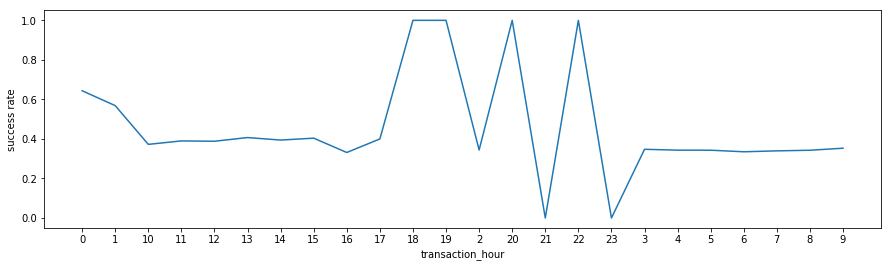

In [34]:
group = 'transaction_hour'
df_plot = txn_hour_gp['successful_rate'].plot(kind="linbe", figsize=(15, 4), xticks = range(24))
df_plot.set(xlabel=group, ylabel="success rate")

In [6]:
pdf_all = pd.read_csv(WORK_DIR + 'TimeOfDay_raw_data.csv')

In [11]:
pdf_all[pdf_all['renew_att_num'] == 5]

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success
97,97,2018-09-15,avgstore,10559980501,7379231503,2018-09-15 06:20:33,5.0,NON3DS,Le Credit Lyonnais,FR,497202.0,Visa,Visa Gold,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0123,RETRY_DECLINED.2,5.0,15,saturday,b3a3fc18-139a-497d-8ebd-30b6b66afcea,283243.0,Debit,FR,DRI*AVG Technologies,1156962062,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,34.99,40.90,EUR,Visa,netgiro-seb,5,34.99,40.90,EUR,52054590900,27001.0,Transaction refused[05] [000000] [] [],New,14218610800,2018-09-15 01:20:33,1,Authorize,0
246,246,2018-09-15,avgstore,12163854101,7382062873,2018-09-15 15:15:52,5.0,48DCD73481A61694,"Wells Fargo Bank, National Association",US,432378.0,Visa,Visa Classic,Consumer,Debit - Debit Hybrid (PIN and Signature),0721,RETRY_DECLINED.2,5.0,15,saturday,bd6fa490-f3ab-4d3a-b689-0afb95442250,309683.0,Debit,US,DRI*AVG Technologies,7236114,DR_INC-ENTITY,Declined,DR_INC-ENTITY,64.99,64.99,USD,Visa,litle,5,64.99,64.99,USD,52084225900,522.0,305: Expired Card,New,17098017100,2018-09-15 10:15:52,10,Authorize,0
256,256,2018-09-15,adbehkr,10216797001,7379161403,2018-09-15 06:09:09,NaN,NON3DS,"HYUNDAICARD CO., LTD.",KR,547227.0,MasterCard,MasterCard BusinessCard Card,Business,Credit - True credit (No PIN/Signature capabil...,1222,NaN,NaN,15,saturday,093343a9-4752-4726-8d32-2b7777369967,NaN,Credit,KR,DRI*Adobe Systems,1156962062,DR_IRELAND-ENTITY,Completed,DR_KOREA-ENTITY,59400.00,53.10,KRW,MasterCard,netgiro-seb,5,59400.00,53.10,KRW,52053806300,0.0,SUCCESS[00] [899438] [] [],New,16787040500,2018-09-15 01:09:09,1,Authorize,1
265,265,2018-09-15,adbehkr,11262629501,7379451203,2018-09-15 06:53:44,NaN,NON3DS,"KB KOOKMIN CARD CO., LTD",KR,527289.0,MasterCard,Standard Debit MasterCard,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0722,RETRY_DECLINED.2,NaN,15,saturday,f33524d3-babb-4a51-abdf-295c972f8b35,NaN,Debit,KR,DRI*Adobe Systems,1411163460,DR_IRELAND-ENTITY,Declined,DR_KOREA-ENTITY,11000.00,9.80,KRW,MasterCard,netgiro-bms,5,11000.00,9.80,KRW,52057159700,27048.0,Lost or stolen card.[41] [] [111800] [111800],New,16788435700,2018-09-15 01:53:44,1,Authorize,0
298,298,2018-09-15,adbehap,12001881301,7379572513,2018-09-15 07:11:29,NaN,NON3DS,SIAM COMMERCIAL BANK PUBLIC COMPANY LIMITED,TH,557755.0,MasterCard,Debit MasterCard Unembossed (Non-US),Consumer,Credit - True credit (No PIN/Signature capabil...,0525,RETRY_DECLINED.2,NaN,15,saturday,614d7df8-3e62-422b-bf78-0c7a64828429,NaN,Credit,TH,DRI*Adobe Sales,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,712.00,21.90,THB,MasterCard,netgiro-bms,5,712.00,21.90,THB,52058696300,27050.0,Do not try again/use alternate payment card.[5...,New,16794533100,2018-09-15 02:11:29,2,Authorize,0
310,310,2018-09-15,avgstore,12164050501,7379697023,2018-09-15 07:27:11,4.0,180915,BPCE,FR,497500.0,Visa,Visa Classic,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0920,RETRY_DECLINED.2,4.0,15,saturday,f57ea2e0-d2f9-432b-a203-eb94266d6e84,284173.0,Debit,FR,AVG*AVG Technologies,207686,AVG-ENTITY,Declined,DR_IRELAND-ENTITY,52.99,61.94,EUR,Visa,paymentech,5,52.99,61.94,EUR,52059874000,530.0,NaN,New,17098207400,2018-09-15 02:27:11,2,Authorize,0
316,316,2018-09-15,adbehap,12001345501,7379566213,2018-09-15 07:10:23,NaN,NON3DS,Banco de Credito del Peru,PE,455788.0,Visa,Visa Classic,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0821,

In [14]:
pdf_all[pdf_all['subsegment_id'] == 16786048800]

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success
1084,1084,2018-09-15,adbehkr,11863982301,7378971573,2018-09-15 05:30:07,NaN,NON3DS,"Shinhan Card Co., Ltd.",KR,436420.0,Visa,Visa Classic,Consumer,Debit - NON USA Consumer Debit - No Pin Access,0521,NaN,NaN,15,saturday,b3f921bc-87a9-4f53-bbff-8cd43966f1e0,NaN,Debit,KR,DRI*Adobe Systems,1156962062,DR_IRELAND-ENTITY,Completed,DR_KOREA-ENTITY,11000.0,9.8,KRW,Visa,netgiro-seb,5,11000.0,9.8,KRW,52051653500,0.0,SUCCESS[00] [342960] [] [],New,16786048800,2018-09-15 00:30:07,0,Authorize,1


In [7]:
import time

import pandas as pd


from pyspark.sql.types import *
from pyspark.sql.functions import col, count, rand, collect_list, explode, struct, count, lit, lower
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import pyspark_cassandra
        
import calendar, datetime
from datetime import timedelta

WORK_DIR = '/var/spark/ml_files/'

def convert_status(value):
    if value == 'Completed' or value == 'Reversed':
        return 1
    else:
        return 0

def _map_to_pandas(rdds):
    """ Needs to be here due to pickling issues """
    return [pd.DataFrame(list(rdds))]

def toPandas(df, n_partitions=None):
    """
    Returns the contents of `df` as a local `pandas.DataFrame` in a speedy fashion. The DataFrame is
    repartitioned if `n_partitions` is passed.
    :param df:              pyspark.sql.DataFrame
    :param n_partitions:    int or None
    :return:                pandas.DataFrame
    """
    if n_partitions is not None: df = df.repartition(n_partitions)
    df_pand = df.rdd.mapPartitions(_map_to_pandas).collect()
    df_pand = pd.concat(df_pand)
    df_pand.columns = df.columns
    return df_pand
    
udfValueToStatus = udf(convert_status, IntegerType())  
createDDL = """CREATE OR REPLACE TEMPORARY VIEW cpg_transaction
     USING org.apache.spark.sql.cassandra
     OPTIONS (
     table "cpg_transaction",
     keyspace "subs",
     cluster "MLP Cluster",
     pushdown "true")"""
spark.sql(createDDL)

# df = spark.sql("SELECT * FROM cpg_transaction_history WHERE received_date > '2018-08-12' ")
df = spark.sql("SELECT * FROM cpg_transaction WHERE received_date > '20180101' and received_date < '20180131'")

sdf =  df\
    .filter("!(renew_att_num == '1' and new_status in ('Completed','Reversed') and cid is null and status == 'New')")\
    .withColumn("success", udfValueToStatus("new_status"))\
    .withColumn("day_of_month", df["day_of_month"].cast(IntegerType()))\
    .withColumn("transaction_hour", df["transaction_hour"].cast(IntegerType()))\
    .withColumn("day_of_week", lower(col("day_of_week")))\
     .cache()

print(sdf.schema)

pdf_all = sdf.toPandas()
# pdf_all = toPandas(sdf, 4)  
pdf_all.shape

StructType(List(StructField(received_date,StringType,true),StructField(site_id,StringType,true),StructField(subscription_id,StringType,true),StructField(event_uuid,StringType,true),StructField(added_expiry_years,StringType,true),StructField(bank_code,StringType,true),StructField(bank_name,StringType,true),StructField(billing_country,StringType,true),StructField(bin,StringType,true),StructField(card_brand,StringType,true),StructField(card_category,StringType,true),StructField(card_class,StringType,true),StructField(card_usage,StringType,true),StructField(cc_expiration_date,StringType,true),StructField(cid,StringType,true),StructField(date_increment,StringType,true),StructField(day_of_month,IntegerType,true),StructField(day_of_week,StringType,true),StructField(exp_setting_id,StringType,true),StructField(funding_source,StringType,true),StructField(issuer_country,StringType,true),StructField(merchant_descriptor,StringType,true),StructField(merchant_number,StringType,true),StructField(mid_e

(1088927, 48)

In [8]:
pdf_all.to_csv(WORK_DIR + 'raw_data_01.csv')

In [9]:
"""Show all columns"""
import pandas as pd
from IPython.display import display

pd.options.display.max_columns = None

pdf_all[(pdf_all['site_id'] == 'avast') & (pdf_all['renew_att_num'] == '3') & (pdf_all['success'] == 1)]

,received_date,site_id,subscription_id,event_uuid,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,...,retry_rule_id,status,subsegment_id,time_of_day_rule_id,transaction_date,transaction_date_in_string,transaction_hour,transaction_id,transaction_type,success
10858,20180122,avast,1913859009,e35bd044-212a-44c4-8928-ae3d17eca989,None,68DF8224A27B3535,None,US,371314,American Express,...,None,New,12682846900,,2018-01-22 06:23:52,2018-01-22 00:23:52,0,6393799733,Authorize,1
10991,20180122,avast,2442557509,56ea8de9-1db2-492b-88c9-8e8a04d85fcc,None,NON3DS,ASB Bank,NZ,428418,Visa,...,None,New,12715568400,,2018-01-22 06:27:16,2018-01-22 00:27:16,0,6393829253,Authorize,1
11001,20180122,avast,2443114609,80c8c5e3-2bd6-4c52-b757-f3d7b6a0128e,None,861562E97799F09A,"CAPITAL ONE BANK (USA), NATIONAL ASSOCIATION",US,517805,MasterCard,...,None,New,12683231700,,2018-01-22 06:27:21,2018-01-22 00:27:21,0,6393830123,Authorize,1
11022,20180122,avast,2443429709,1e58612f-0e32-40df-954a-ebc62fd96a08,None,B45C2B180AE3967B,"FIFTH THIRD BANK, THE",US,544400,MasterCard,...,None,New,12683280500,,2018-01-22 06:27:25,2018-01-22 00:27:25,0,6393831243,Authorize,1
11376,20180122,avast,3027160009,42a90087-5037-4db9-80f3-263e49e1b2ab,None,97E3D94A43F52ABD,"Wells Fargo Bank, National Association",US,446542,Visa,...,None,New,12744316600,,2018-01-22 06:18:23,2018-01-22 00:18:23,0,6393751563,Authorize,1
11468,20180122,avast,3142802009,168f4329-dd33-47aa-9814-030afc2b1eb8,None,RB,BANQUE FEDERATIVE DU CREDIT MUTUEL (BFCM),FR,513272,MasterCard,...,None,New,12715511700,,2018-01-22 06:21:59,2018-01-22 00:21:59,0,6393789253,Authorize,1
11481,20180122,avast,3143097309,0a6e9f2a-7de7-4ea7-9ebf-afb9419c6e40,None,NON3DS,UNICREDIT SPA,IT,526430,MasterCard,...,None,New,12682765300,,2018-01-22 06:21:57,2018-01-22 00:21:57,0,6393788803,Authorize,1
11601,20180122,avast,3145629509,b5649a5b-74c2-4f90-b0bb-d55610f23f52,None,RB,Societe Generale S.A.,FR,497355,Visa,...,None,New,12683058600,,2018-01-22 06:26:38,2018-01-22 00:26:38,0,6393824873,Authorize,1
11668,20180122,avast,3155682809,c7d3a5ad-9e1e-46e5-8e03-1bace71e8a9c,None,NON3DS,MASTER RED EUROPA S.L.,ES,558435,MasterCard,...,None,New,12683429500,,2018-01-22 06:29:20,2018-01-22 00:29:20,0,6393846593,Authorize,1
11702,20180122,avast,3155896409,ea2bd718-43f3-4a93-be45-e3b8eac1e6ff,None,NON3DS,Visa Austria,AT,454818,Visa,...,None,New,12683432700,,2018-01-22 06:29:24,2018-01-22 00:29:24,0,6393847223,Authorize,1
